In [ ]:
!pip install MDAnalysis
!pip install lipyphilic
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 1.7 MB/s eta 0:00:00


In [ ]:
import pathlib
import pickle  # this library is used for saving the analysis objects to file
import joblib
import os

import numpy as np
import MDAnalysis as mda
import lipyphilic as lpp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.mixture
import hmmlearn.hmm
import matplotlib
import plotly.graph_objects as go

from tqdm.auto import tqdm


from lipyphilic.leaflets.assign_leaflets import AssignLeaflets, AssignCurvedLeaflets
from lipyphilic.analysis.order_parameter import SCC
from lipyphilic.analysis.z_angles import ZAngles
from lipyphilic.analysis.area_per_lipid import AreaPerLipid
from lipyphilic.analysis.z_positions import ZPositions
from lipyphilic.analysis.memb_thickness import MembThickness
from lipyphilic.plotting import JointDensity
from lipyphilic.analysis.z_thickness import ZThickness
from lipyphilic.plotting import ProjectionPlot
from lipyphilic.analysis.registration import Registration


from MDAnalysis.analysis.lineardensity import LinearDensity
from MDAnalysis.lib.mdamath  import normal
from MDAnalysis.lib.mdamath import norm
from MDAnalysis.lib.mdamath import angle
from MDAnalysis.lib.mdamath import make_whole


Vamos a chequear los archivos de la carpeta para saber què archivos cargar

In [ ]:
#This cell should be deleted if the files are downloaded and the notebooks executed locally
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Step 1: Define the folder
folder_path = "/content/drive/Shareddrives/Noe-1/Soft-matter-paper/DMs-libres/semiiso_00znpc"

# Step 2: Search for unique `.tpr` and `.xtc` files in the folder
tpr_file = None
xtc_file = None

for fname in os.listdir(folder_path):
    if fname.endswith(".tpr"):
        if tpr_file is not None:
            raise ValueError("More than one .tpr file found in the folder.")
        tpr_file = os.path.join(folder_path, fname)
    elif fname.endswith(".xtc"):
        if xtc_file is not None:
            raise ValueError("More than one .xtc file found in the folder.")
        xtc_file = os.path.join(folder_path, fname)

# Check if both files were found
if tpr_file is None or xtc_file is None:
    raise FileNotFoundError("Could not find both .tpr and .xtc files in the folder.")

# Step 3: Load with MDAnalysis
u = mda.Universe(tpr_file, xtc_file)

print("Trajectory loaded successfully.")

Trajectory loaded successfully.


In [ ]:
results_directory = pathlib.Path(
    "./results/densidad"
)

# Create the directory if it doesn't already exist
results_directory.resolve().mkdir(exist_ok=True, parents=True)

In [ ]:
# Location to store the results
file_root = "dppc00_znpc"

# Densidad

In [ ]:
###  Selecciones para realizar el grafico de densidades
selection_DPPC = u.select_atoms("resname DPPC")
selection_W = u.select_atoms("resname SOL")
selection_CHOL = u.select_atoms("resname CHOL")
selection_Fosf = u.select_atoms("name O7 P8 O9 O10")
selection_Gli = u.select_atoms("name O11 C12 C13 O14 C32 O33")
selection_ZNPC = u.select_atoms("resname ZNPC")



In [ ]:
selection_Lipid = u.select_atoms("resname CHOL DPPC")
ld_Lipid = LinearDensity(selection_Lipid, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
# Ejecuto el analisis de densidades
ld_DPPC = LinearDensity(selection_DPPC, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)

ld_W = LinearDensity(selection_W, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)

ld_Fosf = LinearDensity(selection_Fosf, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)

ld_Gli = LinearDensity(selection_Gli, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)

#ld_PO4 = LinearDensity(selection_PO4, binsize=0.25).run(
#    start=4000,
#    stop=None,
#    step=5,
#    verbose=True
#)

ld_CHOL = LinearDensity(selection_CHOL, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)


ld_ZNPC = LinearDensity(selection_ZNPC, binsize=0.5).run(
    start=None,
    stop=None,
    step=5,
    verbose=True
)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
###Este analisis esta incluido para hacer las lineas de separacion de las regiones
selection_Tail = u.select_atoms("resname DPPC and not (name O* C12 C13 C15 C32 C34 P8  N4 C1 C2 C3 C5 C6 )")

ld_Tail = LinearDensity(selection_Tail, binsize=0.5).run(
    start=4000,
    stop=None,
    step=5,
    verbose=True
)
df_Tail = pd.DataFrame(ld_Tail.results['z']['mass_density'])


  0%|          | 0/1200 [00:00<?, ?it/s]

In [ ]:
# Convert the results to a DataFrame
df_DPPC = pd.DataFrame(ld_DPPC.results['z']['mass_density'])
df_W = pd.DataFrame(ld_W.results['z']['mass_density'])
df_CHOL = pd.DataFrame(ld_CHOL.results['z']['mass_density'])
df_Fosf = pd.DataFrame(ld_Fosf.results['z']['mass_density'])
df_Gli = pd.DataFrame(ld_Gli.results['z']['mass_density'])
df_ZNPC = pd.DataFrame(ld_ZNPC.results['z']['mass_density'])

#df_Gli = pd.DataFrame(ld_Gli.results['z']['mass_density'])
#df_NCH3 = pd.DataFrame(ld_NCH3.results['z']['mass_density'])
#df_PO4 = pd.DataFrame(ld_PO4.results['z']['mass_density'])
ld_W.binsize



0.5

In [ ]:
df_Lipid = pd.DataFrame(ld_Lipid.results['z']['mass_density'])

In [ ]:
new_df = pd.DataFrame()

# Corrijo el centro de masa de los bins

# Select the group of atoms corresponding to "resname POPC"
dppc_atoms = u.select_atoms("resname DPPC")

# Function to calculate the z-center (center of mass in z-dimension) of the group of atoms
def get_z_center_of_mass(atom_group):
    return atom_group.center_of_mass()[2]  # The z-coordinate of the center of mass

# Loop over the trajectory, calculating the z-center of mass for "POPC" atoms
z_centers = []
for ts in u.trajectory:
    z_center = get_z_center_of_mass(dppc_atoms)
    z_centers.append(z_center)
    #print(f"Frame {ts.frame}: z-center of mass = {z_center}")

# If you need the average z-center of mass across all frames
z_center_avg = np.mean(z_centers)

# Assuming new_df is already defined and 'bin' is the column to correct
#new_df['bin_corrected'] = new_df['bin'] - z_center_avg


# Create the first column with ld.nbins elements with a separation of 0.25
new_df['bin'] = (np.arange(ld_W.nbins) * ld_W.binsize) - z_center_avg

# Add the other columns from the existing DataFrames
new_df['DPPC'] = df_DPPC[0]
new_df['W'] = df_W[0]
new_df['CHOL'] = df_CHOL[0]
new_df['Tail'] = df_Tail[0]
new_df['Gli'] = df_Gli[0]
new_df['Fosf'] = df_Fosf[0]
new_df['ZNPC'] = df_ZNPC[0]
new_df['Tail'] = df_Tail[0]
new_df['Lipid'] = df_Lipid[0]


In [ ]:
new_df['Lipid'] = df_Lipid[0]


In [ ]:
## Hago un suavizado de los valores de densidad para que el grafico quede mejor:
# Apply rolling average with window size of 5 (change size as needed)
new_df['DPPC_smooth'] = new_df['DPPC'].rolling(window=5).mean()
new_df['W_smooth'] = new_df['W'].rolling(window=5).mean()
new_df['CHOL_smooth'] = new_df['CHOL'].rolling(window=5).mean()
new_df['Tail_smooth'] = new_df['Tail'].rolling(window=5).mean()
new_df['Gli_smooth'] = new_df['Gli'].rolling(window=5).mean()
new_df['Fosf_smooth'] = new_df['Fosf'].rolling(window=5).mean()
new_df['ZNPC_smooth'] = new_df['ZNPC'].rolling(window=5).mean()
new_df['Tail_smooth'] = new_df['Tail'].rolling(window=5).mean()

In [ ]:
new_df['Lipid_smooth'] = new_df['Lipid'].rolling(window=5).mean()

### ATENCION SI SE CARGA EL DATAFRAME, SE DEBERIA EJECUATR EL COLAB A PARTIR DE ESTA CELDA


In [ ]:
# ## Hago el grafdico de la densidad con Plotly para ver si quedo centrado o no:
## Si cambia edito el valor del Offset para corregir

# Create the plot
fig = go.Figure()

Offset= -0.85

# Add traces for each smoothed line with shading
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['DPPC_smooth'],
                         mode='lines', name='DPPC', line=dict(color='green')))
fig.add_trace(go.Scatter(x=new_df['bin']  - Offset, y=new_df['W_smooth'],
                         mode='lines', name='W', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=new_df['bin']  - Offset, y=new_df['CHOL_smooth'],
                         mode='lines', name='CHOL', line=dict(color='red')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Gli_smooth'],
                         mode='lines', name='Glicerol', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Fosf_smooth'],
                         mode='lines', name='Fosfate', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Tail_smooth'],
                         mode='lines', name='Lipid tail', line=dict(color='black')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5,
                         mode='lines', name='ZNPC', line=dict(color='lightblue')))
fig.add_trace(go.Scatter(x=new_df['bin'] - Offset, y=new_df['Lipid_smooth'],
                         mode='lines', name='Lipids', line=dict(color='lightblue')))

# Customize the layout
fig.update_layout(
    title='Linear Density Profile with Moving Average Smoothing',
    xaxis_title='z(Å)',
    yaxis_title='Density (g/mL)',
    legend_title='Components',
    template='plotly_white',
    width=800,
    height=600
)

# Show the plot
fig.show()


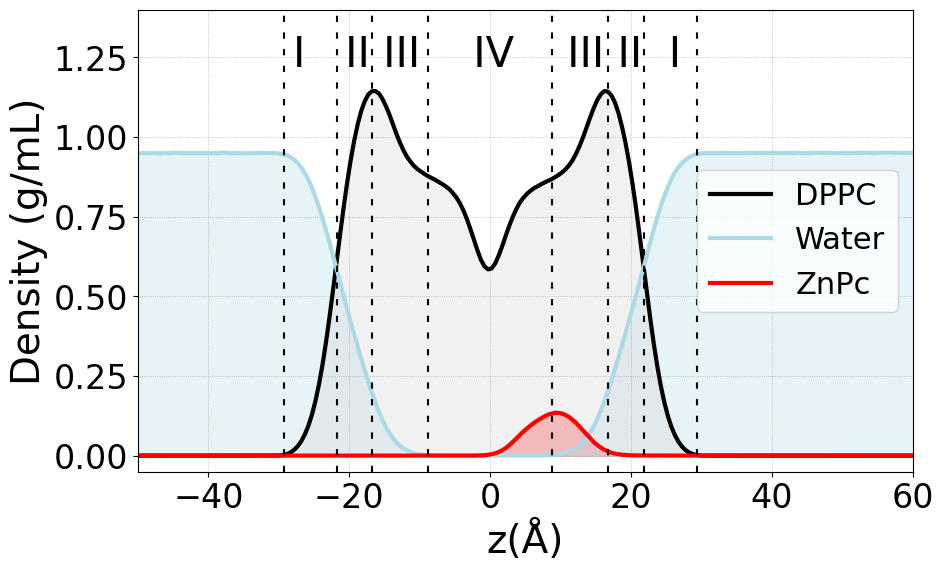

In [ ]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the smoothed lines with shading
sns.lineplot(x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='DPPC', color='black',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='Water', color='lightblue', linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='CHOL_smooth', data=new_df, label='CHOL', color=CHOL_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Gli_smooth', data=new_df, label='Glicerol', color=SAPE_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Tail_smooth', data=new_df, label='Lipid tails', color=SAPI_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Fosf_smooth', data=new_df, label='Fosfates', color='black', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5, data=new_df, label='ZnPc', linewidth=3.0, color='red')

# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 5, color='red', alpha=0.3)
# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['W_smooth'], color='lightblue', alpha=0.3)
plt.fill_between(new_df['bin'] - Offset, new_df['Lipid_smooth'], color='lightgray', alpha=0.3)


# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed

# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['Lipid_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=equal_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['Lipid_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    dppc_x_2 = dppc_x * (-1)
    plt.axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=dppc_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)

plt.axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)



# Add labels and title
plt.xlabel('z(Å)',fontsize=28)
plt.ylabel('Density (g/mL)',fontsize=28)
#plt.title('Linear Density Profile ',fontsize=28)

# Add legend
plt.legend(fontsize=24)
plt.xlim(-50, 60)
plt.ylim(-0.05, 1.40)
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)

plt.text(
    -28, 1.22,  # x, y coordinates of the text in data units
    'I   II III    IV    III II  I',  # The text to display
    fontsize=30,  # Font size of the text
    bbox=dict(facecolor='white', alpha=0.0,edgecolor='white' )  # Text box style
)

# Add legend
plt.legend(fontsize=22)

# Show the plot
plt.show()


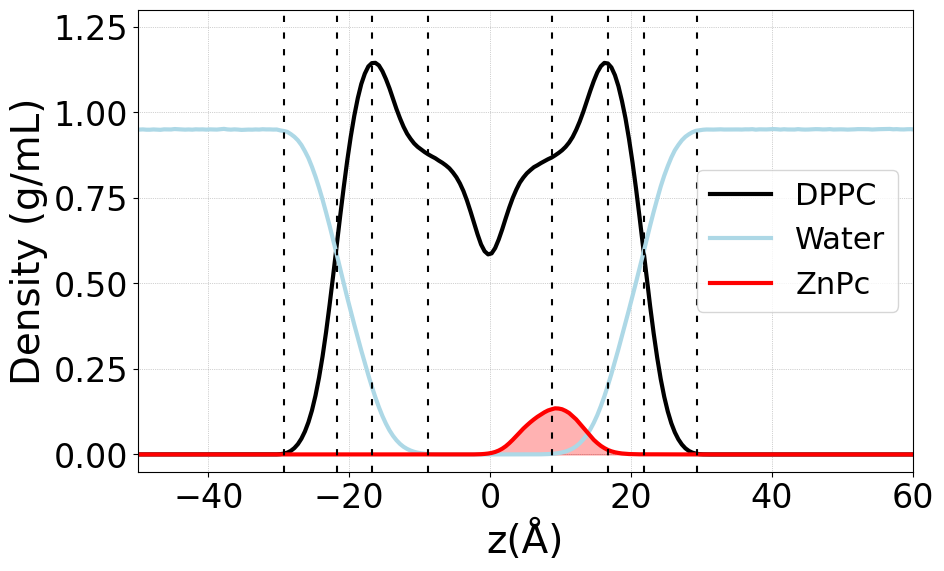

In [ ]:

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the smoothed lines with shading
sns.lineplot(x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='DPPC', color='black',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='Water', color='lightblue', linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='CHOL_smooth', data=new_df, label='CHOL', color=CHOL_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Gli_smooth', data=new_df, label='Glicerol', color=SAPE_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Tail_smooth', data=new_df, label='Lipid tails', color=SAPI_color, linewidth=3.0)
#sns.lineplot(x=new_df['bin'] - Offset, y='Fosf_smooth', data=new_df, label='Fosfates', color='black', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5, data=new_df, label='ZnPc', linewidth=3.0, color='red')

# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 5, color='red', alpha=0.3)



# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed

# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['Lipid_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=equal_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['Lipid_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    dppc_x_2 = dppc_x * (-1)
    plt.axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
    plt.axvline(x=dppc_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)

plt.axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)
plt.axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=1.5, label=None)



# Add labels and title
plt.xlabel('z(Å)',fontsize=28)
plt.ylabel('Density (g/mL)',fontsize=28)
#plt.title('Linear Density Profile ',fontsize=28)

# Add legend
plt.legend(fontsize=24)
plt.xlim(-50, 60)
plt.ylim(-0.05, 1.30)
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
plt.grid(True, which='both', linestyle=':', linewidth=0.5, color='gray', alpha=0.7)



# Add legend
plt.legend(fontsize=22)

# Show the plot
plt.show()


In [ ]:
# Los valores de referencia para los limites de las Regiones son:
print(dppc_x_2)
print(equal_x_2)
print(max_gli_x_2)
print(max_tail_x_2)

print(max_tail_x)
print(max_gli_x)
print(equal_x)
print(dppc_x)


29.29333182526056
21.79333182526056
-16.70666817473944
8.79333182526056
-8.79333182526056
16.70666817473944
-21.79333182526056
-29.29333182526056


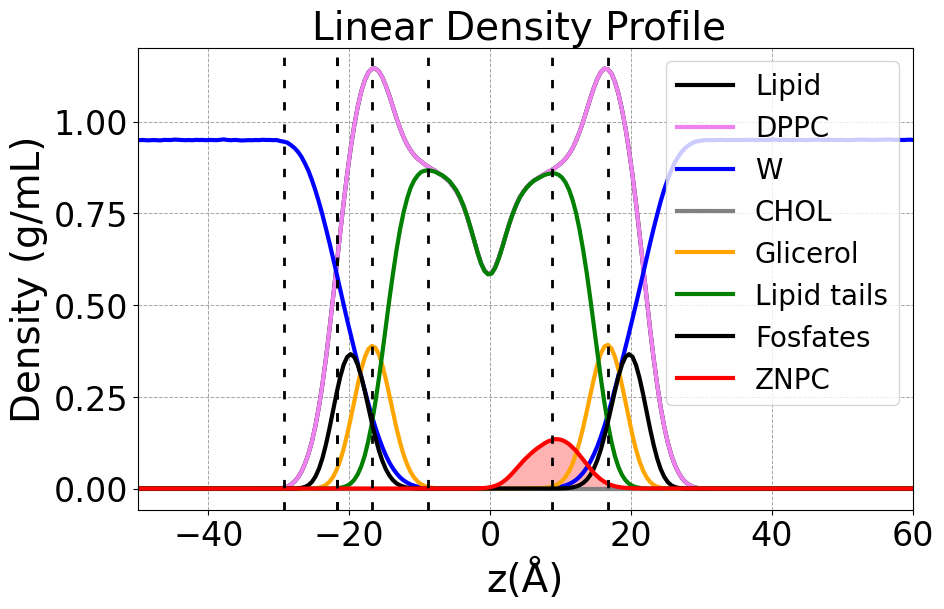

In [ ]:
# En este grafico estan graficadas todas las densidades, es solo informativo, no es para version final:


# Create the plot
plt.figure(figsize=(10, 6))

# Plot the smoothed lines with shading
sns.lineplot(x=new_df['bin'] - Offset , y='Lipid_smooth', data=new_df, label='Lipid', color='black',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset , y='DPPC_smooth', data=new_df, label='DPPC', color='violet',  linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='W_smooth', data=new_df, label='W', color='blue', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='CHOL_smooth', data=new_df, label='CHOL', color='gray', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='Gli_smooth', data=new_df, label='Glicerol', color='orange', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='Tail_smooth', data=new_df, label='Lipid tails', color='green', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y='Fosf_smooth', data=new_df, label='Fosfates', color='black', linewidth=3.0)
sns.lineplot(x=new_df['bin'] - Offset, y=new_df['ZNPC_smooth'] * 5, data=new_df, label='ZNPC', linewidth=3.0, color='red')

# Add labels and title
plt.xlabel('z(Å)',fontsize=28)
plt.ylabel('Density (g/mL)',fontsize=28)
plt.title('Linear Density Profile ',fontsize=28)

# Add legend
plt.legend(fontsize=24)
plt.xlim(-50, 60)
plt.tick_params(axis='both', which='major', labelsize=24)  # Increase tick label size
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.7)



# Fill the area under ZNPC_smooth curve
plt.fill_between(new_df['bin'] - Offset, new_df['ZNPC_smooth'] * 5, color='red', alpha=0.3)

# Add a dotted line at the maximum of Gli_smooth series
max_gli_y = new_df['Gli_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_gli_x = new_df['bin'][new_df['Gli_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_gli_x_2 = max_gli_x * (-1)

max_tail_y = new_df['Tail_smooth'].max()  # Find the maximum y-value in Gli_smooth
max_tail_x = new_df['bin'][new_df['Tail_smooth'].idxmax()] - Offset  # Corresponding x-value with Offset applied
max_tail_x_2 = max_tail_x * (-1)


# Set tolerance values to make np.isclose less strict
tolerance_rtol = 1e-2  # Relative tolerance, can be adjusted as needed
tolerance_atol = 1e-1  # Absolute tolerance, can be adjusted as needed

# Find the points where W_smooth and DPPC_smooth are approximately equal
equal_point = new_df[np.isclose(new_df['W_smooth'], new_df['DPPC_smooth'], rtol=tolerance_rtol, atol=tolerance_atol)]
if not equal_point.empty:
    equal_x = equal_point['bin'].iloc[0] - Offset
    equal_x_2 = equal_x * (-1)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)
    plt.axvline(x=equal_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)


# Find the point where DPPC_smooth is higher than 0.1 and plot a vertical line
dppc_point = new_df[new_df['DPPC_smooth'] > 0.001]
if not dppc_point.empty:
    dppc_x = dppc_point['bin'].iloc[0] - Offset
    plt.axvline(x=dppc_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)

plt.axvline(x=max_gli_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
plt.axvline(x=max_gli_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2)
plt.axvline(x=max_tail_x, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)
plt.axvline(x=max_tail_x_2, color='black', linestyle=(0, (3, 5, 3, 5)), linewidth=2, label=None)


# Add legend
plt.legend(fontsize=20)

# Show the plot
plt.show()


In [ ]:
# Define the file path
file_path = r'linear_density-OK.csv'

# Get the directory path and ensure it exists
directory_path = os.path.abspath(os.path.dirname(file_path))
os.makedirs(directory_path, exist_ok=True)

# Save the DataFrame to the CSV file
new_df.to_csv(file_path, index=False)  # Set index=False to exclude the index column in the CSV file


In [ ]:
### Listo el DataFrame guardado
### Si quisiera leer el DataFrame para modificar graficos, o el analisis:

# Define la ruta del archivo
# file_path = file_path = r'linear_density-OK.csv'


# Leer el archivo CSV
#new_df = pd.read_csv(file_path)

### SE podria usar el colab a aprtir de la celda que grafica con PLOTLY

